In [3]:
!pip3 install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Silhouette Score: 0.188


/var/folders/wv/nmvg2kvx7ns_8xhm99sdtmfm0000gn/T/ipykernel_25217/1075557727.py:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


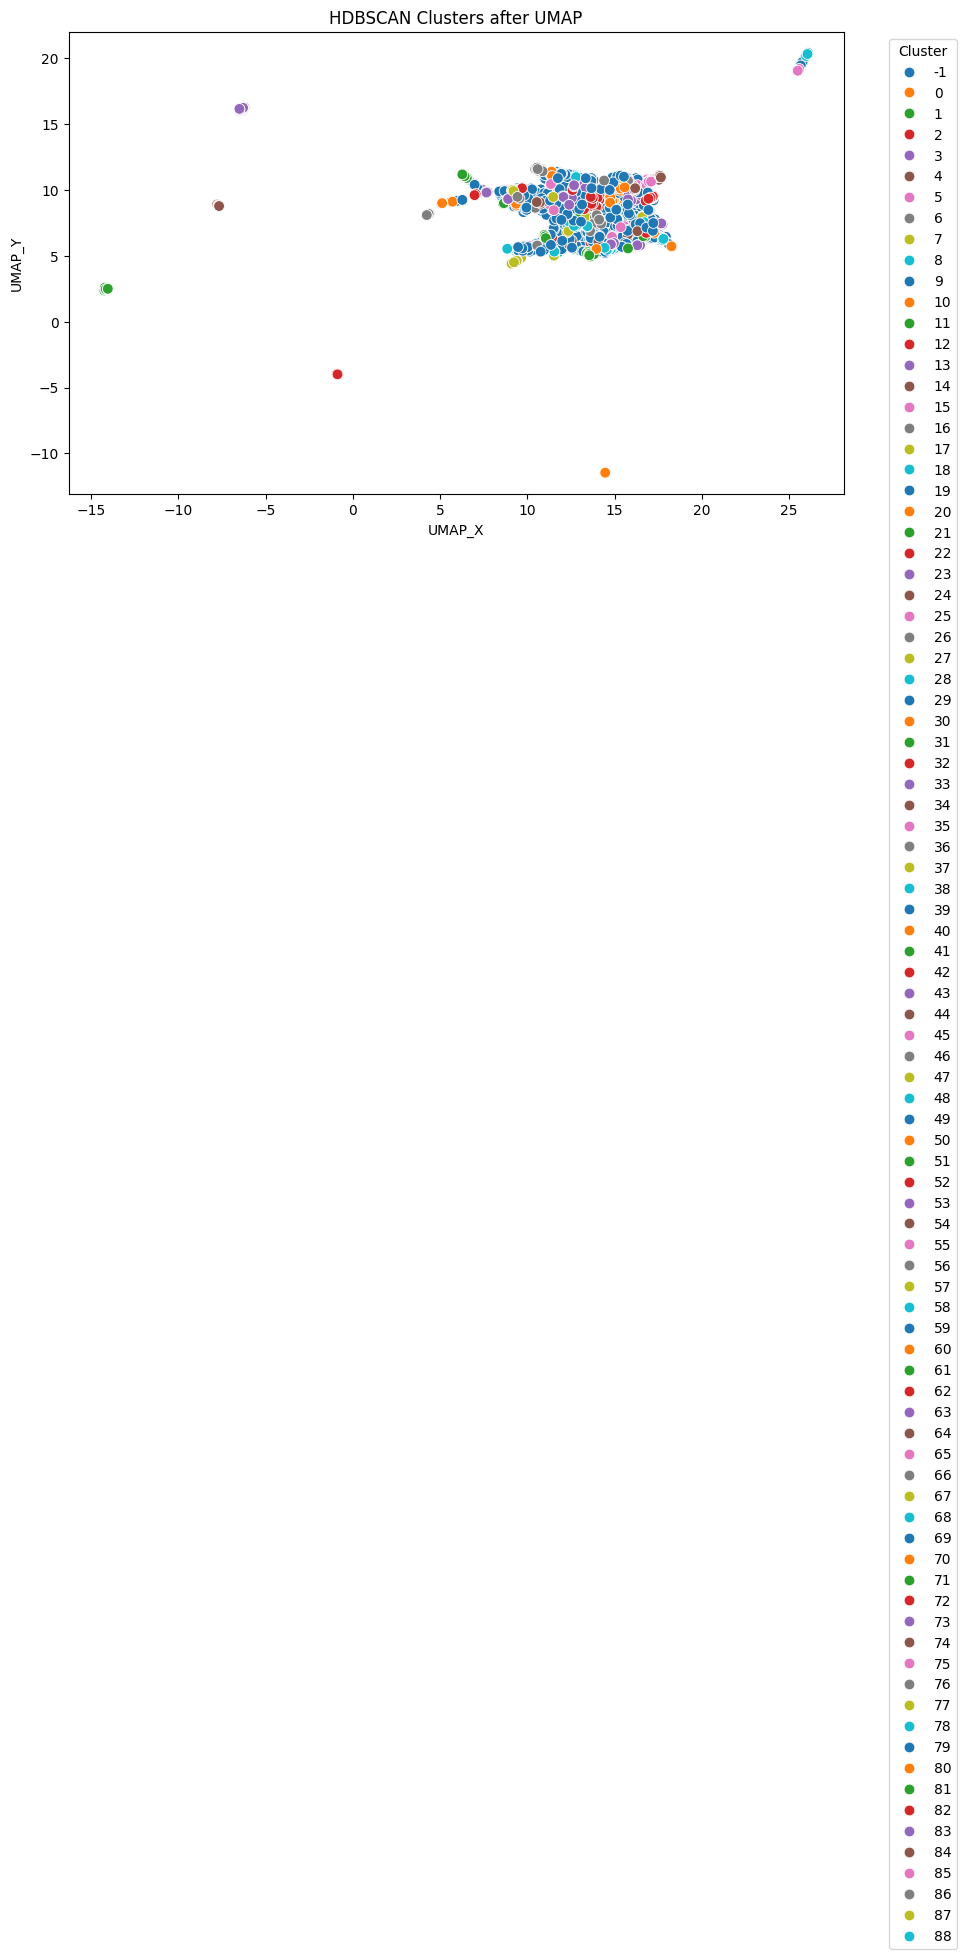


🔍 Cluster -1 - Top Repositories:
Repositories
dotfiles     239
homebrew      68
docs          39
bootstrap     30
rails         30
Name: count, dtype: int64

🔍 Cluster 0 - Top Repositories:
Repositories
Unknown    22
Name: count, dtype: int64

🔍 Cluster 1 - Top Repositories:
Repositories
Unknown    105
Name: count, dtype: int64

🔍 Cluster 2 - Top Repositories:
Repositories
Unknown    21
Name: count, dtype: int64

🔍 Cluster 3 - Top Repositories:
Repositories
Unknown    102
Name: count, dtype: int64

🔍 Cluster 4 - Top Repositories:
Repositories
Unknown    50
Name: count, dtype: int64

🔍 Cluster 5 - Top Repositories:
Repositories
Unknown    47
Name: count, dtype: int64

🔍 Cluster 6 - Top Repositories:
Repositories
git-presentation     2
eatingsafe           2
Stanford-CMDBf-XA    2
sfget                1
homebrew-core        1
Name: count, dtype: int64

🔍 Cluster 7 - Top Repositories:
Repositories
Unknown                       17
chrisgriffin                   1
airbyte                  

In [5]:
# Step 1: Import libraries
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import umap
import hdbscan
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load your cleaned user data
df = pd.read_csv("../data/cleaned_github_users.csv")

# Step 3: Preprocess 'Languages' column and user behavior features
df['Languages'] = df['Languages'].fillna('Unknown')
df['Language_List'] = df['Languages'].apply(lambda x: [lang.strip() for lang in x.split(",")])

mlb = MultiLabelBinarizer()
lang_encoded = mlb.fit_transform(df['Language_List'])

# Select user behavior features (make sure these columns exist in your dataset)
behavior_features = df[['Followers', 'Following', 'Public_Repos']].fillna(0)

# Step 4: Combine language and behavior features safely

# Convert lang_encoded to dataframe with string column names
lang_encoded_df = pd.DataFrame(lang_encoded, columns=[f'Lang_{lang}' for lang in mlb.classes_])

# Reset index and concatenate safely
combined_features = pd.concat([lang_encoded_df.reset_index(drop=True), behavior_features.reset_index(drop=True)], axis=1)

# Standardize the combined features
combined_features_scaled = StandardScaler().fit_transform(combined_features)


# Step 5: Apply UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
embedding = reducer.fit_transform(combined_features)

# Step 6: Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
labels = clusterer.fit_predict(embedding)

# Step 7: Assign results back to dataframe
df['UMAP_X'] = embedding[:, 0]
df['UMAP_Y'] = embedding[:, 1]
df['Cluster'] = labels

# Step 8: Evaluate clustering (only if more than 1 cluster exists)
if len(set(labels)) > 1 and not all(label == -1 for label in labels):
    sil_score = silhouette_score(embedding, labels)
    print(f"Silhouette Score: {sil_score:.3f}")
else:
    print("Silhouette Score not applicable (only one cluster or all noise).")

# Step 9: Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='UMAP_X', y='UMAP_Y', hue='Cluster', data=df, palette='tab10', s=60)
plt.title("HDBSCAN Clusters after UMAP")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Step 10: (Optional) Inspect cluster compositions
for cluster_id in sorted(df['Cluster'].unique()):
    print(f"\n🔍 Cluster {cluster_id} - Top Repositories:")
    subset = df[df['Cluster'] == cluster_id]
    repo_list = subset['Repositories'].dropna().str.split(', ').explode()
    top_repos = repo_list.value_counts().head(5)
    print(top_repos)

In [7]:
!pip3 install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [8]:
import optuna
import umap
import hdbscan
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import pandas as pd
import numpy as np

# ------------------------
# Load and prepare your data (same as before)
df = pd.read_csv("../data/cleaned_github_users.csv")
df['Languages'] = df['Languages'].fillna('Unknown')
df['Language_List'] = df['Languages'].apply(lambda x: [lang.strip() for lang in x.split(",")])

mlb = MultiLabelBinarizer()
lang_encoded_df = pd.DataFrame(mlb.fit_transform(df['Language_List']), columns=[f'Lang_{lang}' for lang in mlb.classes_])

behavior_features = df[['Followers', 'Following', 'Public_Repos']].fillna(0).reset_index(drop=True)

combined_features = pd.concat([lang_encoded_df.reset_index(drop=True), behavior_features], axis=1)
combined_features_scaled = StandardScaler().fit_transform(combined_features)
# ------------------------

# ------------------------
# Define Optuna objective
def objective(trial):
    # UMAP parameters
    n_neighbors = trial.suggest_int('n_neighbors', 5, 100)
    min_dist = trial.suggest_float('min_dist', 0.0, 0.9)
    
    # HDBSCAN parameters
    min_cluster_size = trial.suggest_int('min_cluster_size', 5, 50)

    # Apply UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric='euclidean', random_state=42)
    embedding = reducer.fit_transform(combined_features_scaled)

    # Apply HDBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean')
    labels = clusterer.fit_predict(embedding)
    
    # Check for valid clustering
    if len(set(labels)) <= 1 or np.all(labels == -1):
        return -1.0  # Invalid clustering

    # Silhouette Score
    score = silhouette_score(embedding, labels)
    return score
# ------------------------

# ------------------------
# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# ------------------------
# Show best parameters and score
print(f"✅ Best Silhouette Score: {study.best_value:.3f}")
print(f"✅ Best Parameters: {study.best_params}")


[I 2025-05-16 01:08:56,833] A new study created in memory with name: no-name-4a699e53-22a1-440b-a12e-a87459b2b884
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed 

✅ Best Silhouette Score: 0.922
✅ Best Parameters: {'n_neighbors': 90, 'min_dist': 0.7702595630216392, 'min_cluster_size': 40}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Clustered data saved to: ../data/hdbscan_optuna_clustered_users.csv


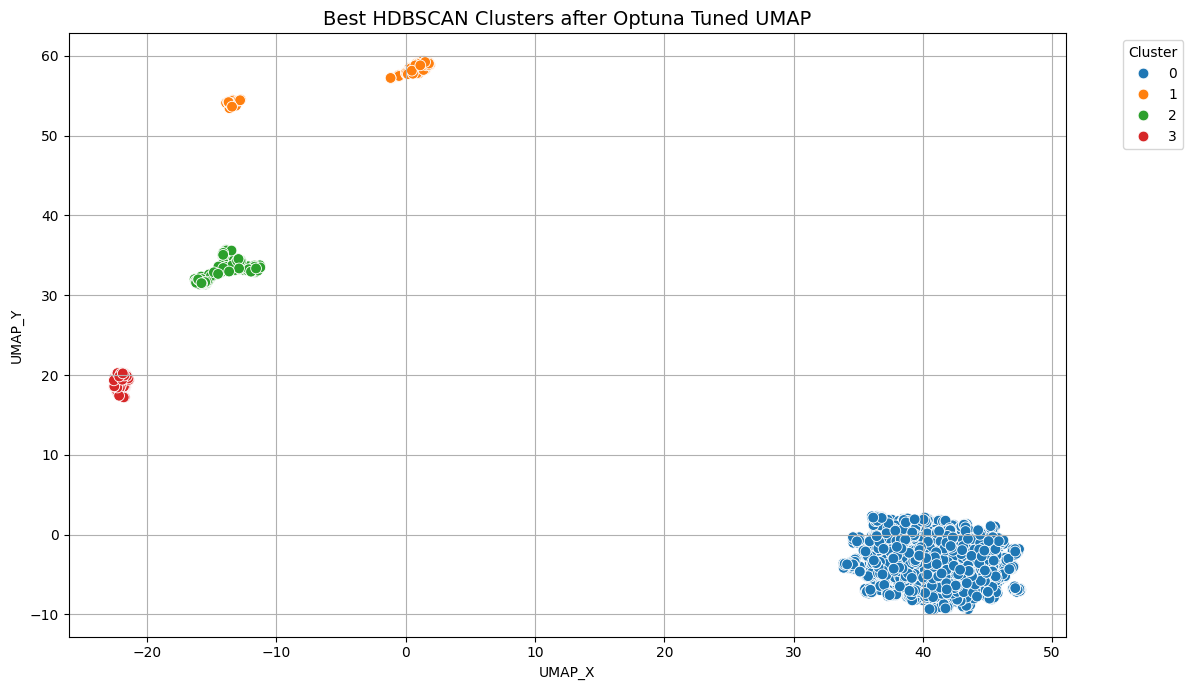


🔍 Top Repositories per Cluster:

Cluster 0 - Top Repositories:
Repositories
dotfiles    692
homebrew    154
rails       118
docs        117
bundler     114
Name: count, dtype: int64

Cluster 1 - Top Repositories:
Repositories
Unknown    194
Name: count, dtype: int64

Cluster 2 - Top Repositories:
Repositories
Unknown              71
test                  2
eatingsafe            2
Stanford-CMDBf-XA     2
for_reel              2
Name: count, dtype: int64

Cluster 3 - Top Repositories:
Repositories
Unknown    176
Name: count, dtype: int64


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import hdbscan
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# -----------------------------
# Step 1: Load your cleaned user data
df = pd.read_csv("../data/cleaned_github_users.csv")

# Step 2: Preprocess 'Languages' column and user behavior features
df['Languages'] = df['Languages'].fillna('Unknown')
df['Language_List'] = df['Languages'].apply(lambda x: [lang.strip() for lang in x.split(",")])

mlb = MultiLabelBinarizer()
lang_encoded_df = pd.DataFrame(mlb.fit_transform(df['Language_List']), columns=[f'Lang_{lang}' for lang in mlb.classes_])

behavior_features = df[['Followers', 'Following', 'Public_Repos']].fillna(0).reset_index(drop=True)

# Step 3: Combine language and behavior features, then scale
combined_features = pd.concat([lang_encoded_df.reset_index(drop=True), behavior_features], axis=1)
combined_features_scaled = StandardScaler().fit_transform(combined_features)

# -----------------------------
# Step 4: Apply UMAP + HDBSCAN with best parameters found from Optuna
reducer = umap.UMAP(n_neighbors=90, min_dist=0.7702595630216392, metric='euclidean', random_state=42)
embedding = reducer.fit_transform(combined_features_scaled)

clusterer = hdbscan.HDBSCAN(min_cluster_size=40, metric='euclidean')
labels = clusterer.fit_predict(embedding)

# -----------------------------
# Step 5: Save the clustered data to CSV
df['UMAP_X'] = embedding[:, 0]
df['UMAP_Y'] = embedding[:, 1]
df['Cluster'] = labels

output_csv_path = '../data/hdbscan_optuna_clustered_users.csv'
df.to_csv(output_csv_path, index=False)
print(f"✅ Clustered data saved to: {output_csv_path}")

# -----------------------------
# Step 6: Plot the clustered data
plt.figure(figsize=(12, 7))
sns.scatterplot(x='UMAP_X', y='UMAP_Y', hue='Cluster', data=df, palette='tab10', s=60)
plt.title("Best HDBSCAN Clusters after Optuna Tuned UMAP", fontsize=14)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# Step 7: Show top repositories per cluster
print("\n🔍 Top Repositories per Cluster:")
for cluster_id in sorted(df['Cluster'].unique()):
    print(f"\nCluster {cluster_id} - Top Repositories:")
    subset = df[df['Cluster'] == cluster_id]
    repo_list = subset['Repositories'].dropna().str.split(', ').explode()
    top_repos = repo_list.value_counts().head(5)
    print(top_repos)


In [10]:
# Step 5.1: Assign manual Domain Tags based on your cluster knowledge
cluster_domains = {
    0: "DevOps & Scripting",
    1: "Unknown Users",
    2: "Testing & Sparse Data",
    3: "Unknown Users"
    # Continue for other clusters as per your observation
}

# Apply mapping
df['Domain_Tag'] = df['Cluster'].map(cluster_domains)


In [11]:
# Save the updated dataframe
df.to_csv('../data/hdbscan_optuna_clustered_users_with_domain.csv', index=False)
print("✅ Clustered data with domain tags saved.")


✅ Clustered data with domain tags saved.
